In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [164]:
df = pd.read_csv("../saved_data/indicator_3_RDD.csv", sep=";")
df["week"] = pd.to_datetime(df["week"].map(lambda d: str(d) + '-0'), format="%Y%W-%w")
df = df.pivot_table(index=["week"], columns=['geo_name'], values='inc')
df = df.reset_index()

# prepare data
# - a year is a list of 12 regions with, for each, 54 data points, one for each week

# linearize time
df["week_cos"] = np.cos(df["week"].dt.isocalendar().week / 52)
df["week_sin"] = np.sin(df["week"].dt.isocalendar().week / 52)

# build train and test sets
years = df["week"].dt.year.unique()
years_train = np.random.choice(years, size=int(0.8 * len(years)), replace=False)
train_df = df[df["week"].dt.year.isin(years_train)]
test_df = df[~df["week"].dt.year.isin(years_train)]

train_df = train_df.drop(["week"], axis=1)
test_df = test_df.drop(["week"], axis=1)


# normalize data
train_mean = train_df.mean()
train_std = train_df.std()
train_df = (train_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std
val_df = test_df.copy()

num_features = train_df.shape[1]

In [165]:
train_df.columns

Index(['AUVERGNE-RHONE-ALPES', 'BOURGOGNE-FRANCHE-COMTE', 'BRETAGNE',
       'CENTRE-VAL-DE-LOIRE', 'CORSE', 'GRAND EST', 'HAUTS-DE-FRANCE',
       'ILE-DE-FRANCE', 'NORMANDIE', 'NOUVELLE-AQUITAINE', 'OCCITANIE',
       'PAYS-DE-LA-LOIRE', 'PROVENCE-ALPES-COTE-D-AZUR', 'week_cos',
       'week_sin'],
      dtype='object', name='geo_name')

In [166]:
targets = ['ILE-DE-FRANCE']
column_indices = {name: i for i, name in enumerate(train_df.columns)}

In [167]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [168]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [169]:
def plot(self, model=None, plot_col=targets[0], max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue
    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      print(self.label_indices.shape, predictions.shape)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Week')

WindowGenerator.plot = plot

In [170]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [171]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

# Windows

In [153]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=targets)

n_predictions = 5
wide_window = WindowGenerator(
    input_width=30, label_width=30, shift=n_predictions,
    label_columns=targets)

# Baseline

In [154]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [155]:
baseline = Baseline(label_index=column_indices[targets[0]])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val, return_dict=True)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0, return_dict=True)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9767 - mean_absolute_error: 0.5412  


(30,) (32, 30, 1)
(30,) (32, 30, 1)
(30,) (32, 30, 1)


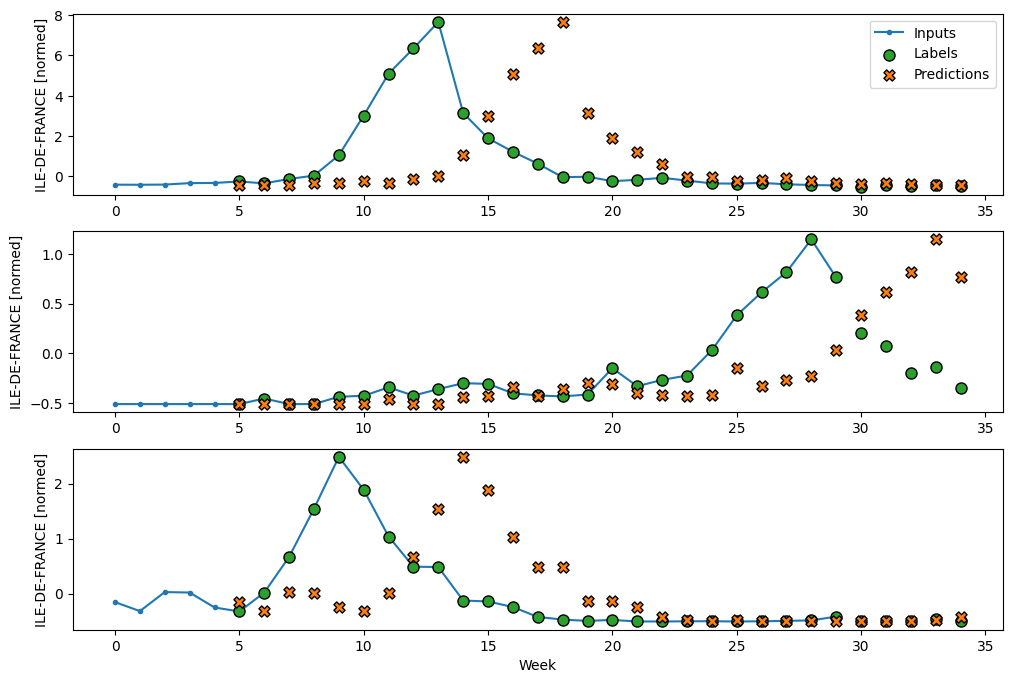

In [156]:
wide_window.plot(baseline)

# Linear Model

In [122]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=len(targets))
])
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', linear(wide_window.example[0]).shape)

Input shape: (32, 24, 15)
Output shape: (32, 24, 1)


In [123]:
MAX_EPOCHS = 100

def compile_and_fit(model, window, patience=10):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [124]:
history = compile_and_fit(linear, wide_window)

val_performance['Linear'] = linear.evaluate(wide_window.val, return_dict=True)
performance['Linear'] = linear.evaluate(wide_window.test, verbose=0, return_dict=True)

Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.9062 - mean_absolute_error: 0.7175 - val_loss: 1.3505 - val_mean_absolute_error: 0.7063
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4834 - mean_absolute_error: 0.6822 - val_loss: 1.3498 - val_mean_absolute_error: 0.7200
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3518 - mean_absolute_error: 0.6668 - val_loss: 1.3057 - val_mean_absolute_error: 0.7111
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3149 - mean_absolute_error: 0.6597 - val_loss: 1.2415 - val_mean_absolute_error: 0.6976
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2552 - mean_absolute_error: 0.6447 - val_loss: 1.1795 - val_mean_absolute_error: 0.6842
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2522 - mean_absolute_error: 0.6370 - val_loss: 1.1161 - val_mean_absolute_error: 0.6680
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1860 - mean_absolute_error: 0.6233 - val_loss

(24,) (32, 24, 1)
(24,) (32, 24, 1)
(24,) (32, 24, 1)


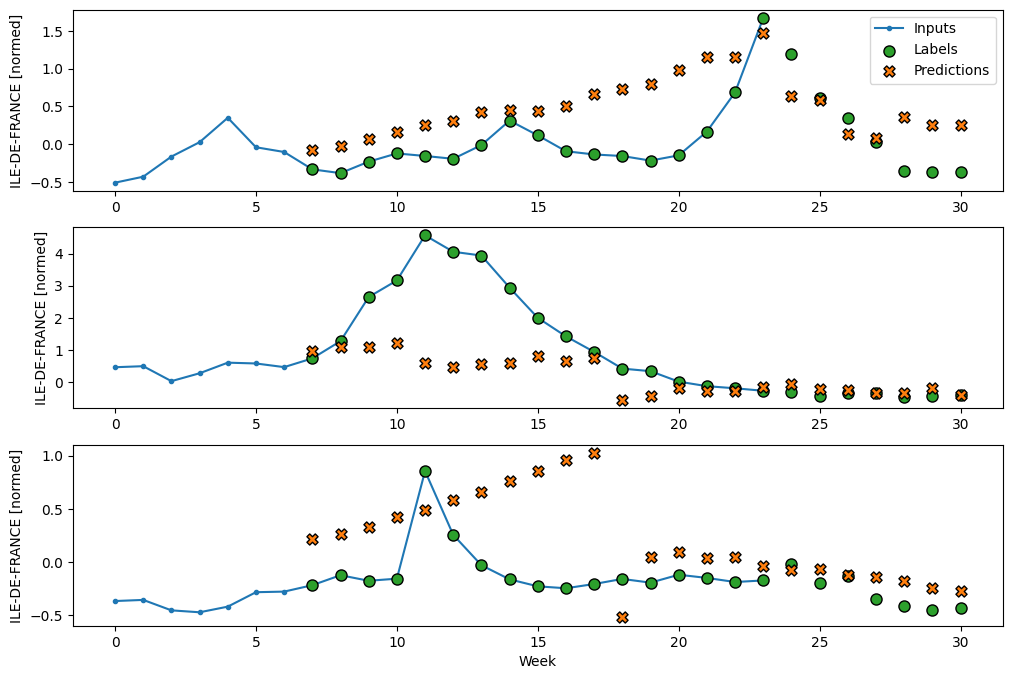

In [125]:
wide_window.plot(linear)

# Dense model

In [135]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(units=len(targets))
])

history = compile_and_fit(dense, wide_window)

val_performance['Dense'] = dense.evaluate(wide_window.val, return_dict=True)
performance['Dense'] = dense.evaluate(wide_window.test, verbose=0, return_dict=True)

Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.9478 - mean_absolute_error: 0.5187 - val_loss: 0.5505 - val_mean_absolute_error: 0.4266
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7632 - mean_absolute_error: 0.4599 - val_loss: 0.5113 - val_mean_absolute_error: 0.4119
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7153 - mean_absolute_error: 0.4375 - val_loss: 0.5238 - val_mean_absolute_error: 0.4121
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6805 - mean_absolute_error: 0.4163 - val_loss: 0.5242 - val_mean_absolute_error: 0.4205
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6570 - mean_absolute_error: 0.4082 - val_loss: 0.5339 - val_mean_absolute_error: 0.4164
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6389 - mean_absolute_error: 0.3922 - val_loss: 0.5490 - val_mean_absolute_error: 0.4172
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.6434 - mean_absolute_error: 0.3885 - val_lo

(24,) (32, 24, 1)
(24,) (32, 24, 1)
(24,) (32, 24, 1)


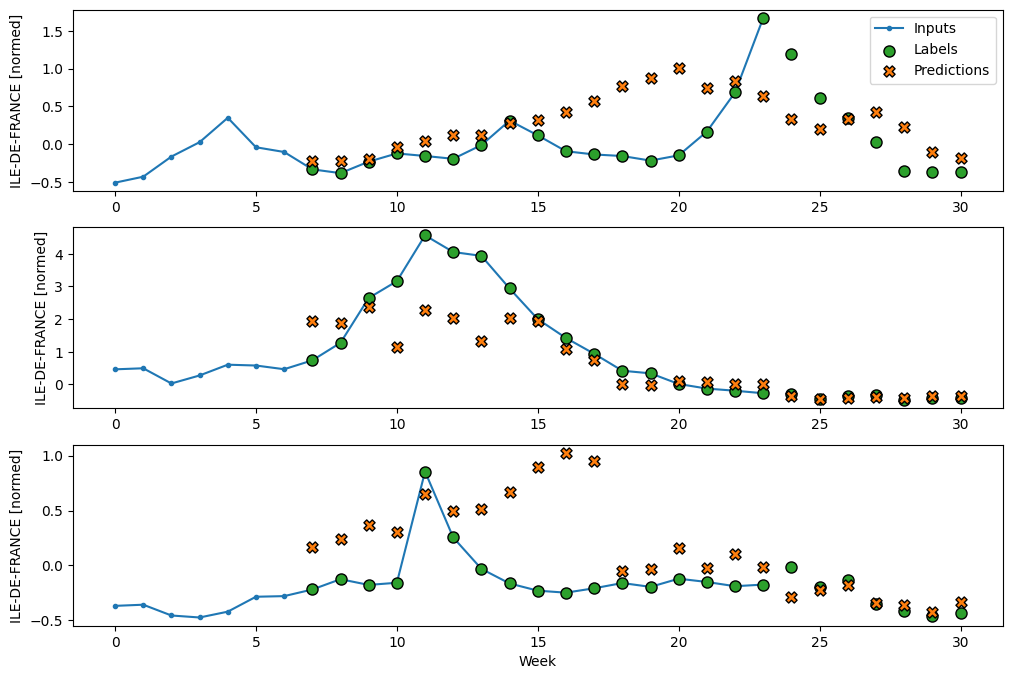

In [136]:
wide_window.plot(dense)

# RNN (LSTM)

In [143]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=len(targets))
])

In [144]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val, return_dict=True)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0, return_dict=True)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6807 - mean_absolute_error: 0.4132


(24,) (32, 24, 1)
(24,) (32, 24, 1)
(24,) (32, 24, 1)


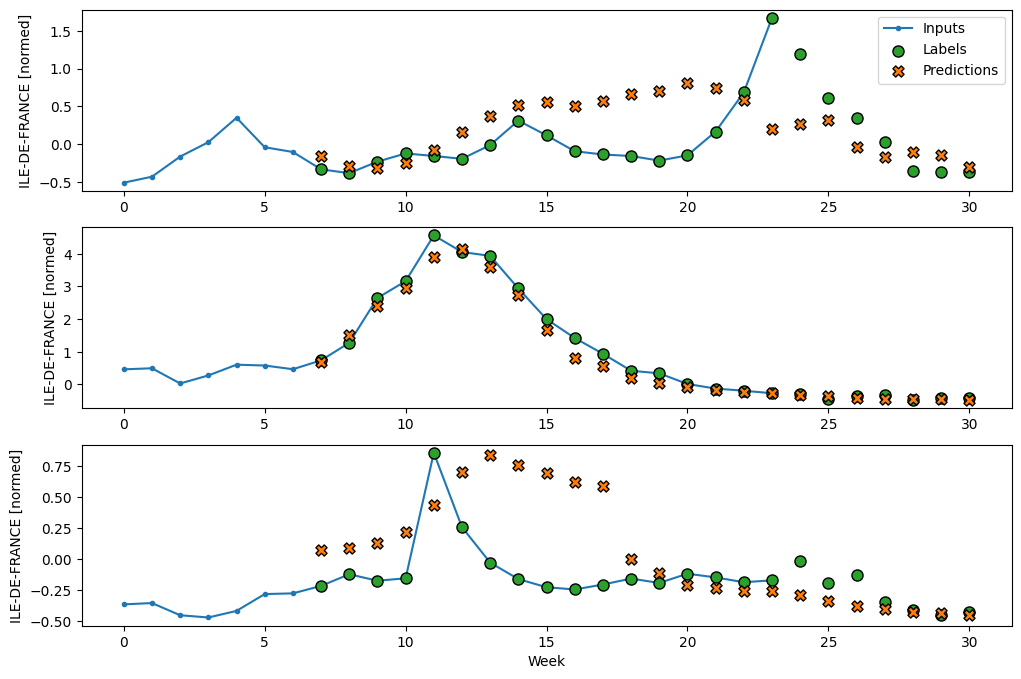

In [145]:
wide_window.plot(lstm_model)

# Performances

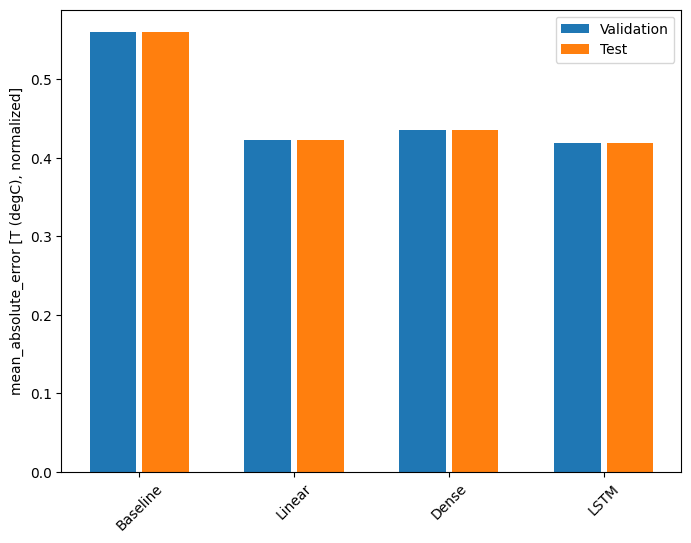

In [140]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

# Multi steps

Total window size: 60
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59]
Label column name(s): None

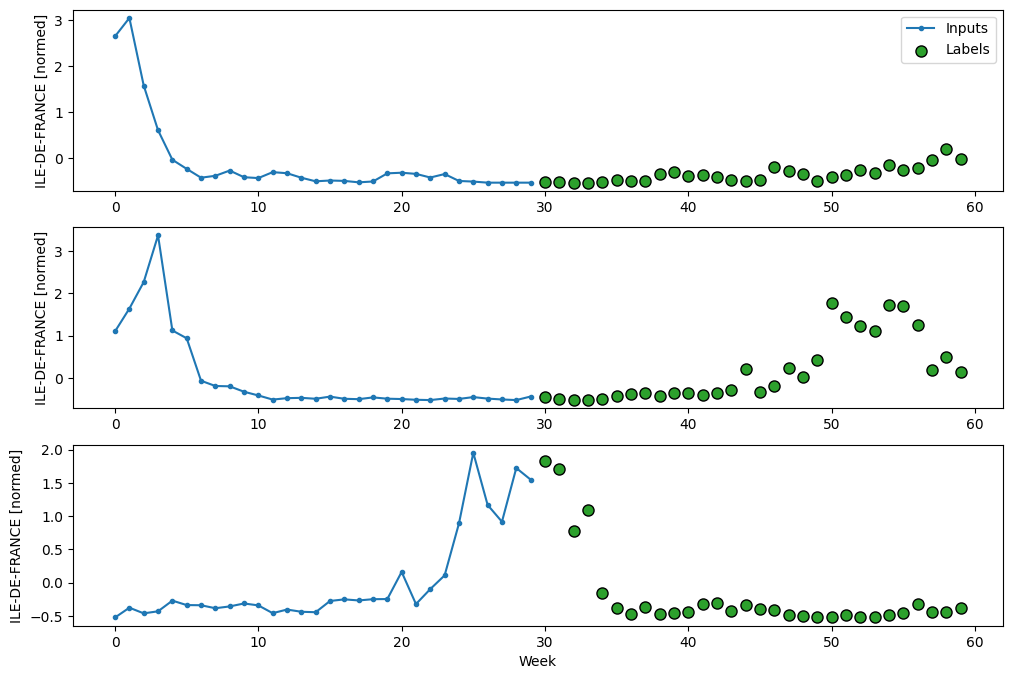

In [181]:
OUT_STEPS = 30
multi_window = WindowGenerator(input_width=30,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.0253 - mean_absolute_error: 0.7866  
(30,) (32, 30, 15)
(30,) (32, 30, 15)
(30,) (32, 30, 15)


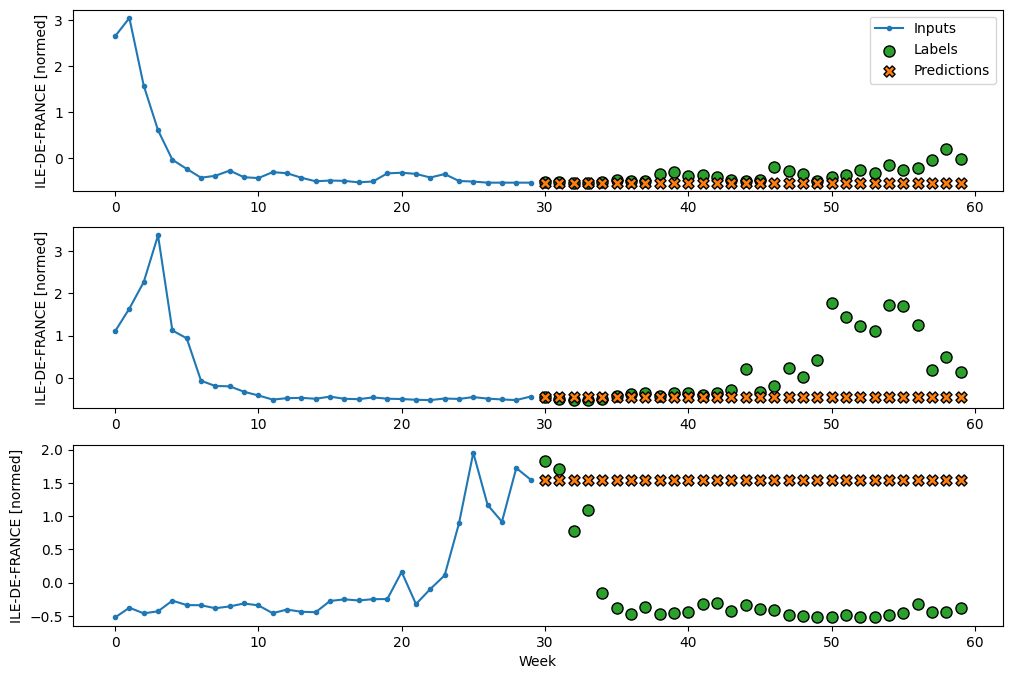

In [182]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val, return_dict=True)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(last_baseline)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.2668 - mean_absolute_error: 0.9312  
(30,) (32, 30, 15)
(30,) (32, 30, 15)
(30,) (32, 30, 15)


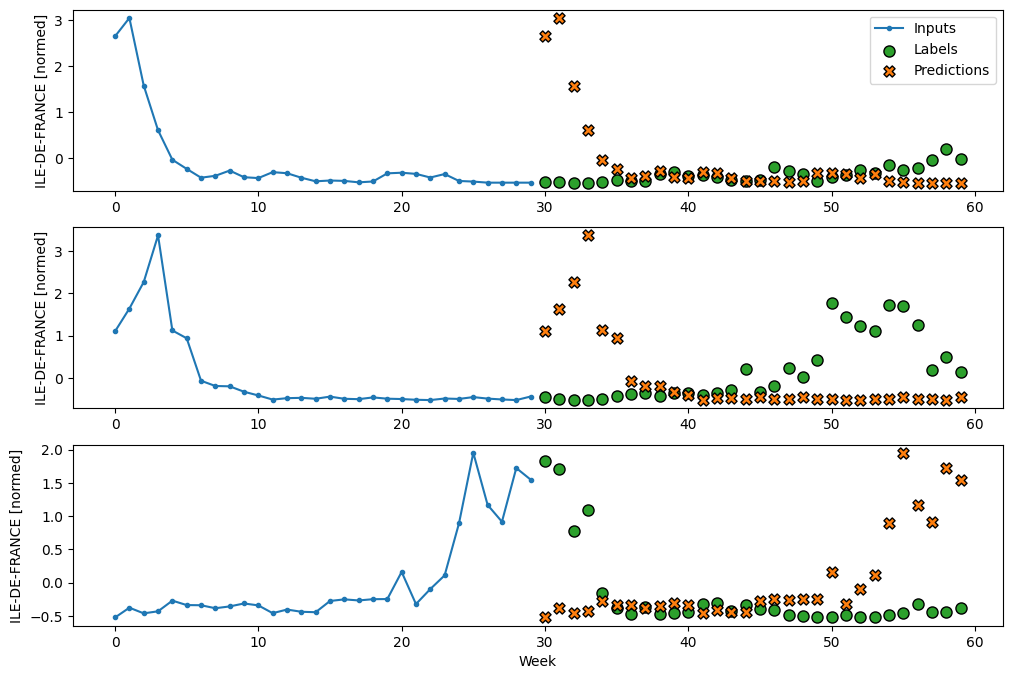

In [183]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val, return_dict=True)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(repeat_baseline)

# Multi linear

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7039 - mean_absolute_error: 0.4547 
(30,) (32, 30, 15)
(30,) (32, 30, 15)
(30,) (32, 30, 15)


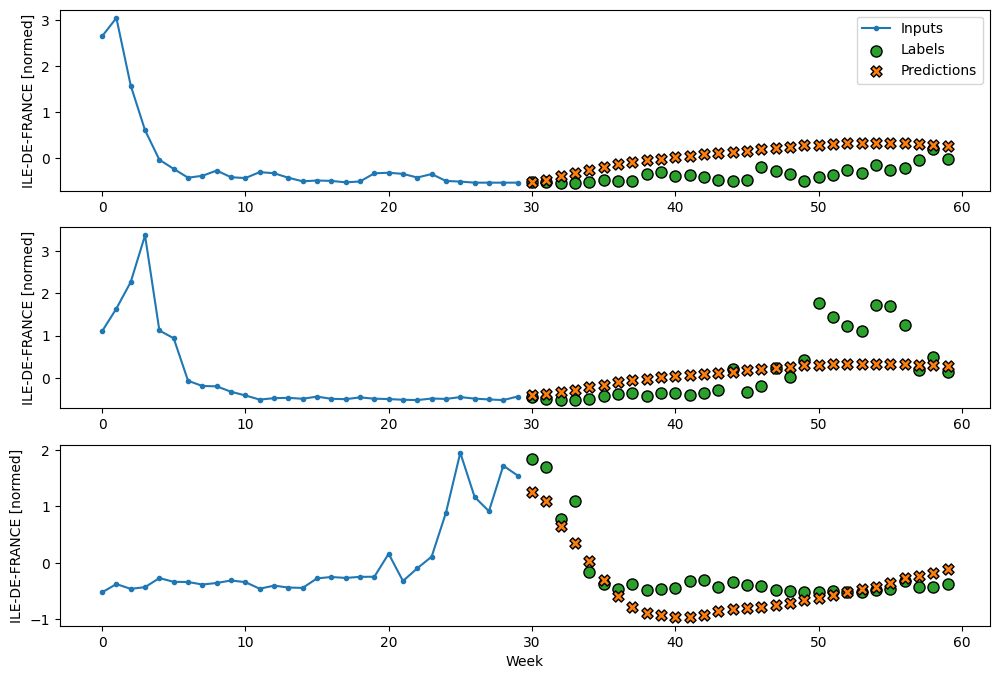

In [184]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val, return_dict=True)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_linear_model)

# Multi dense

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6685 - mean_absolute_error: 0.4036 
(30,) (32, 30, 15)
(30,) (32, 30, 15)
(30,) (32, 30, 15)


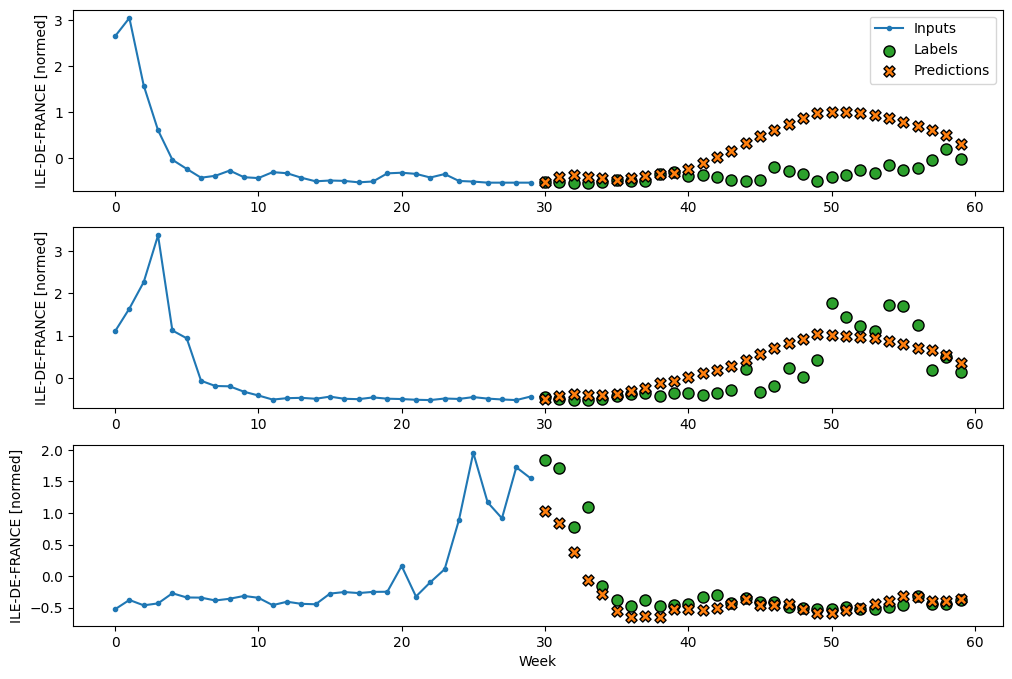

In [185]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val, return_dict=True)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_dense_model)

# Convolutionnal

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6830 - mean_absolute_error: 0.4066 
(30,) (32, 30, 15)
(30,) (32, 30, 15)
(30,) (32, 30, 15)


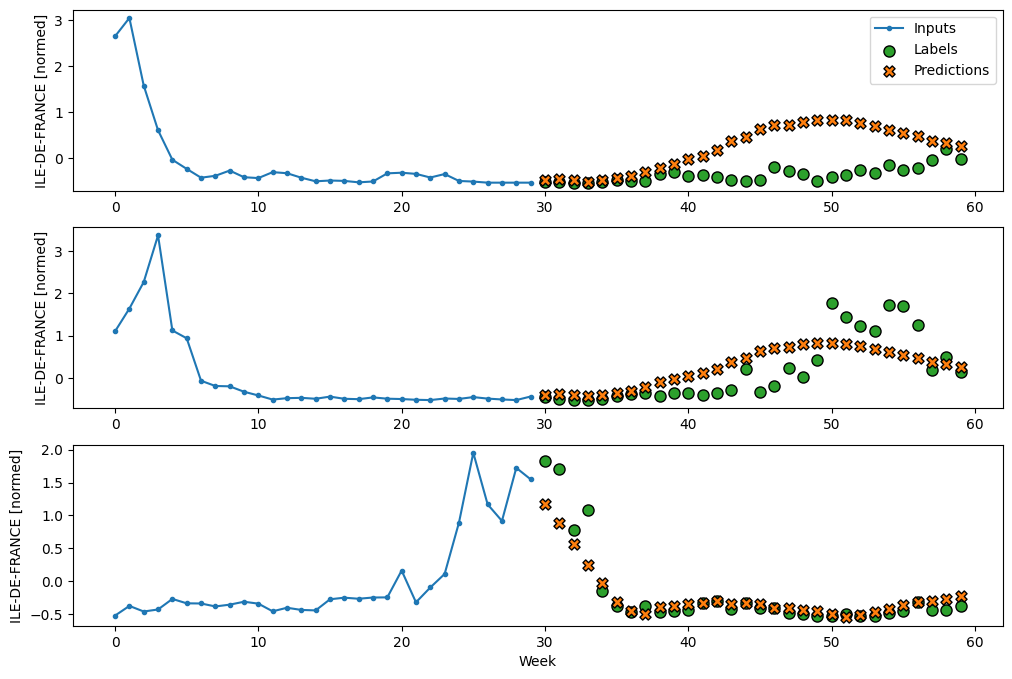

In [186]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val, return_dict=True)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_conv_model)

# LSTM

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7738 - mean_absolute_error: 0.3984
(30,) (32, 30, 15)
(30,) (32, 30, 15)
(30,) (32, 30, 15)


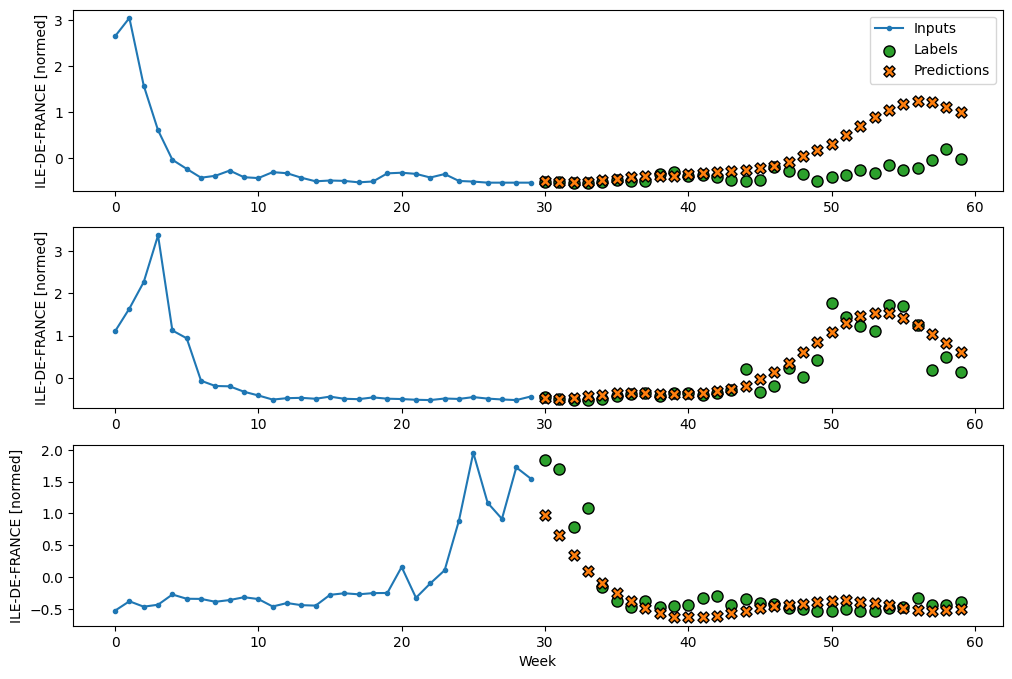

In [187]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val, return_dict=True)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_lstm_model)

# Performances

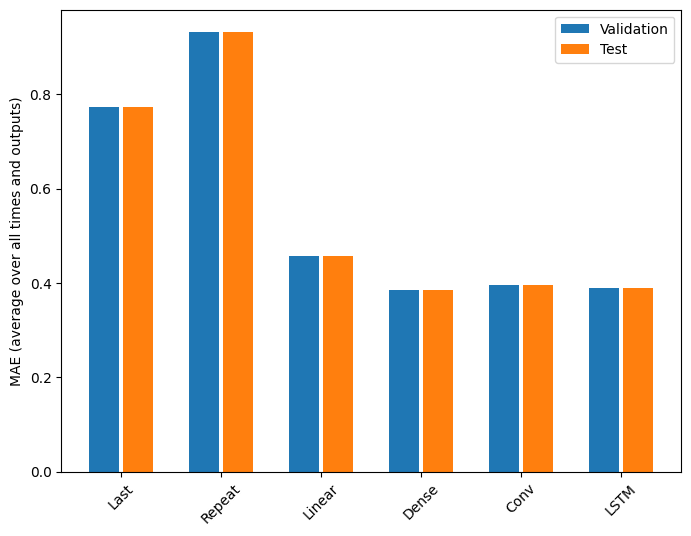

In [188]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
val_mae = [v[metric_name] for v in multi_val_performance.values()]
test_mae = [v[metric_name] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()